# Simple regression model

In [1]:
from toolbox import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SelectFromModel

## Load data

In [4]:
ws = load_weather_station_data('./data/weather_station_list.csv')
w = load_weather_data('./data/weather_collections/weather_daily_region.csv')

gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
g = load_groundwater_data('./data/groundwater/bergstraße/gw.csv')

gs_agg = calc_aggregate_station_data(gs, g)
gs_agg = calc_initial_station_data(gs_agg, g, 1)


In [5]:
g_merged = merge_groundwater_data(g, gs_agg)
g_merged.describe()

,station_id,date,water_dist,water_level,water_depth,water_temp,x,y,start_date,end_date,...,measure_elev,lifespan,water_level_mean,water_depth_mean,water_temp_mean,ini_1_years_water_depth_mean,ini_1_years_water_depth_std,ini_1_years_water_depth_min,ini_1_years_water_depth_max,water_depth_anomaly
count,557260.000000,557260,554273.000000,554273.000000,554273.000000,66890.00000,557260.000000,5.572600e+05,557260,557260,...,557260.000000,557260,557247.000000,557247.000000,144944.000000,556583.000000,556583.000000,556583.000000,556583.000000,553695.000000
mean,13589.102144,1995-03-01 05:35:27.078921728,3.594004,89.469690,3.220631,12.27388,465759.276823,5.501905e+06,1966-12-22 22:03:30.291784800,2017-11-11 00:57:30.511431168,...,93.146810,18586 days 02:54:00.219646208,89.466250,3.222664,12.190641,3.008068,0.225393,2.528968,3.361641,0.211620
min,12890.000000,1912-10-15 00:00:00,0.000000,81.140000,-0.870000,2.02000,453983.000000,5.487354e+06,1912-01-01 00:00:00,1966-01-01 00:00:00,...,86.500000,134 days 00:00:00,83.935770,0.968683,10.746667,0.634151,0.014618,-0.080000,0.750000,-5.058679
25%,13157.000000,1980-08-25 00:00:00,2.500000,86.900000,2.100000,11.30000,461900.003000,5.497120e+06,1953-01-01 00:00:00,2024-03-01 00:00:00,...,90.520000,15765 days 00:00:00,86.885700,2.210565,11.493786,1.873333,0.125076,1.360000,2.230000,-0.444151
50%,13568.000000,1997-12-01 00:00:00,3.360000,89.240000,3.030000,12.00000,466857.965000,5.501588e+06,1973-01-01 00:00:00,2024-03-01 00:00:00,...,93.220000,18322 days 00:00:00,89.014528,3.028495,11.959470,2.806538,0.182364,2.220000,3.110000,0.151321
75%,13774.000000,2013-08-22 00:00:00,4.400000,92.090000,4.040000,12.90000,469927.000000,5.505957e+06,1978-01-01 00:00:00,2024-03-01 00:00:00,...,95.760000,23801 days 00:00:00,91.933931,4.000772,12.636749,3.892075,0.266639,3.390000,4.270000,0.794151
max,17794.000000,2024-03-20 00:00:00,11.160000,96.270000,10.790000,21.30000,473615.000000,5.514651e+06,2013-01-01 00:00:00,2024-03-01 00:00:00,...,100.560000,40968 days 00:00:00,94.533442,8.493808,14.117103,9.955283,0.800611,9.080000,10.740000,5.858491
std,609.112889,NaN,1.527469,3.005891,1.476485,1.55057,4829.443303,6.203696e+03,NaN,NaN,...,3.032113,6842 days 14:06:22.419255168,2.932930,1.320438,0.818067,1.638374,0.150243,1.723007,1.620462,1.138328


In [6]:
g_merged.head()

,station_id,date,water_dist,water_level,water_depth,water_temp,x,y,start_date,end_date,...,lifespan,geometry,water_level_mean,water_depth_mean,water_temp_mean,ini_1_years_water_depth_mean,ini_1_years_water_depth_std,ini_1_years_water_depth_min,ini_1_years_water_depth_max,water_depth_anomaly
date,,,,,,,,,,,,,,,,,,,,,
1979-01-01,13595,1979-01-01,9.48,89.76,8.45,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,16861 days,POINT (8.56426 49.62114),90.031838,8.178162,NaN,9.3975,0.25816,8.45,9.65,-0.9475
1979-01-08,13595,1979-01-08,9.49,89.75,8.46,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,16861 days,POINT (8.56426 49.62114),90.031838,8.178162,NaN,9.3975,0.25816,8.45,9.65,-0.9375
1979-01-15,13595,1979-01-15,9.89,89.35,8.86,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,16861 days,POINT (8.56426 49.62114),90.031838,8.178162,NaN,9.3975,0.25816,8.45,9.65,-0.5375
1979-01-29,13595,1979-01-29,9.98,89.26,8.95,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,16861 days,POINT (8.56426 49.62114),90.031838,8.178162,NaN,9.3975,0.25816,8.45,9.65,-0.4475
1979-02-05,13595,1979-02-05,10.00,89.24,8.97,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,16861 days,POINT (8.56426 49.62114),90.031838,8.178162,NaN,9.3975,0.25816,8.45,9.65,-0.4275


In [7]:
m = pd.merge(g_merged, w,
             how='left', left_index=True, right_index=True)

# restrict data to the post-war period
m = m.loc[m.date > pd.to_datetime('1950-01-01')]

# drop all rows with a date after the weather data cutoff date
m = m.loc[m.date <= pd.to_datetime('2022-12-31')]

m = m.dropna(subset=['station_id_count'])

m['week_of_year'] = m['date'].dt.isocalendar().week

In [8]:
#m.info()

In [9]:
m.describe()

,station_id,date,water_dist,water_level,water_depth,water_temp,x,y,start_date,end_date,...,moisture_std,precip_mean_prev_7d_sum,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,week_of_year
count,535080.000000,535080,532286.000000,532286.000000,532286.000000,58281.000000,535080.000000,5.350800e+05,535080,535080,...,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.0
mean,13584.383032,1995-01-26 12:10:28.768782208,3.605169,89.464313,3.229522,12.234722,465762.831671,5.501887e+06,1967-01-27 18:55:06.768333728,2017-11-06 20:27:37.017267712,...,5.245498,13.079499,56.048417,168.136895,681.624260,10.443488,10.444661,10.441032,10.405230,26.661774
min,12890.000000,1950-01-02 00:00:00,0.000000,81.140000,-0.870000,2.020000,453983.000000,5.487354e+06,1912-01-01 00:00:00,1966-01-01 00:00:00,...,0.000000,0.000000,0.325000,41.320000,422.628571,-11.031746,-8.513333,-4.064444,7.622348,1.0
25%,13159.000000,1980-11-03 00:00:00,2.500000,86.900000,2.110000,11.300000,461900.003000,5.497120e+06,1953-01-01 00:00:00,2024-03-01 00:00:00,...,3.656045,2.975000,33.757143,127.200000,596.247024,4.785714,4.592000,4.935926,9.895108,14.0
50%,13564.000000,1997-05-26 00:00:00,3.370000,89.240000,3.040000,12.000000,466857.965000,5.501538e+06,1973-01-01 00:00:00,2024-03-01 00:00:00,...,4.979960,9.500000,51.760000,163.850000,679.457143,10.403571,10.344762,10.422540,10.424680,27.0
75%,13773.000000,2012-11-19 00:00:00,4.410000,92.100000,4.070000,12.800000,469937.000000,5.505957e+06,1978-01-01 00:00:00,2024-03-01 00:00:00,...,6.601767,19.200000,73.871429,204.142857,762.800000,16.451020,16.551667,16.147460,10.970466,40.0
max,17794.000000,2022-12-31 00:00:00,11.160000,96.270000,10.790000,21.300000,473615.000000,5.514651e+06,2013-01-01 00:00:00,2024-03-01 00:00:00,...,22.487033,122.671429,214.471429,384.700000,1032.071429,28.671429,24.437778,22.301852,12.782055,53.0
std,599.613919,NaN,1.521245,2.998210,1.477947,1.549757,4850.075874,6.171791e+03,NaN,NaN,...,2.275008,12.889888,30.296119,54.912199,111.445324,7.094874,6.682626,5.995027,0.837589,15.052767


## Create intuitive dummy model

As baseline, we can assume that water_depth is proportional to temp.

In [10]:
def dummy_model(t):
    return 0.05 * t + 2

dummy_model(10)

2.5

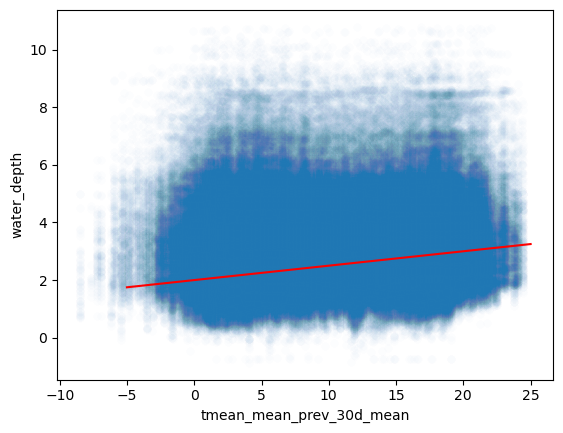

In [11]:
m_plot = m[['tmean_mean_prev_30d_mean', 'water_depth']].reset_index()
m_plot

sns.scatterplot(data=m_plot, 
            x='tmean_mean_prev_30d_mean', y='water_depth',
            alpha=0.01)
            
# works but is very slow (takes 10 minutes)
#sns.kdeplot(data=m_plot, 
#            x='tmean_mean_prev_30d_mean', y='water_depth',
               #alpha=0.01
#           )

x1, x2 = -5, 25
plt.plot([x1, x2],[dummy_model(x1), dummy_model(x2)], 'r');
            

## Train-test split

In [12]:
#m.columns.unique()

In [13]:
# restrict data
df = m[['station_id',
        'date',
        'water_depth',
        'ground_elev',
        'ini_1_years_water_depth_mean',
        'ini_1_years_water_depth_std',
        'ini_1_years_water_depth_min',
        'ini_1_years_water_depth_max',
        'precip_mean',
        'tmean_mean',
        'moisture_mean',
        'precip_mean_prev_7d_sum',
        'precip_mean_prev_30d_sum',
        'precip_mean_prev_90d_sum',
        'tmean_mean_prev_7d_mean',
        'tmean_mean_prev_30d_mean',
        'tmean_mean_prev_90d_mean'
       ]]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 535080 entries, 1950-01-02 to 2022-12-31
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   station_id                    535080 non-null  int64         
 1   date                          535080 non-null  datetime64[ns]
 2   water_depth                   532286 non-null  float64       
 3   ground_elev                   535080 non-null  float64       
 4   ini_1_years_water_depth_mean  534403 non-null  float64       
 5   ini_1_years_water_depth_std   534403 non-null  float64       
 6   ini_1_years_water_depth_min   534403 non-null  float64       
 7   ini_1_years_water_depth_max   534403 non-null  float64       
 8   precip_mean                   535080 non-null  float64       
 9   tmean_mean                    535080 non-null  float64       
 10  moisture_mean                 535080 non-null  float64       
 1

In [14]:
df[df.isna().any(axis=1)]

,station_id,date,water_depth,ground_elev,ini_1_years_water_depth_mean,ini_1_years_water_depth_std,ini_1_years_water_depth_min,ini_1_years_water_depth_max,precip_mean,tmean_mean,moisture_mean,precip_mean_prev_7d_sum,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean
date,,,,,,,,,,,,,,,,,
1950-08-15,12926,1950-08-15,NaN,89.20,3.343750,0.239325,2.72,3.63,0.000000,19.175000,69.428571,8.662500,100.250000,261.150000,19.533929,19.599167,19.460139
1951-07-16,13490,1951-07-16,NaN,90.13,2.404138,0.106050,2.16,2.54,0.477778,14.722222,81.125000,14.888889,81.166667,210.955556,19.669841,18.000370,15.442469
1951-07-16,12895,1951-07-16,NaN,87.21,0.893529,0.327107,0.17,1.56,0.477778,14.722222,81.125000,14.888889,81.166667,210.955556,19.669841,18.000370,15.442469
1951-07-16,13726,1951-07-16,NaN,93.50,2.139677,0.266639,1.63,2.61,0.477778,14.722222,81.125000,14.888889,81.166667,210.955556,19.669841,18.000370,15.442469
1951-07-16,13489,1951-07-16,NaN,88.23,1.195517,0.407533,-0.05,1.57,0.477778,14.722222,81.125000,14.888889,81.166667,210.955556,19.669841,18.000370,15.442469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,12901,2022-12-12,NaN,90.56,3.137500,0.095834,2.94,3.27,0.000000,-2.825000,85.625000,0.075000,52.050000,223.150000,0.439286,4.616667,9.841667
2022-12-19,13764,2022-12-19,NaN,96.13,4.980755,0.291329,4.64,5.53,0.025000,0.925000,85.060000,1.050000,22.325000,190.075000,-3.746429,1.835000,8.528333
2022-12-19,12901,2022-12-19,NaN,90.56,3.137500,0.095834,2.94,3.27,0.025000,0.925000,85.060000,1.050000,22.325000,190.075000,-3.746429,1.835000,8.528333


In [15]:
df = df.dropna()

In [16]:
ids = list(df.station_id.unique())

# Calculate 80% of the list's length
num_elements = round(len(ids) * 0.8)

# Randomly select 80% of the elements
train_ids = random.sample(ids, k=num_elements)

In [17]:
train = df.loc[df.station_id.isin(train_ids)]
test = df.loc[~df.station_id.isin(train_ids)]

In [18]:
train

,station_id,date,water_depth,ground_elev,ini_1_years_water_depth_mean,ini_1_years_water_depth_std,ini_1_years_water_depth_min,ini_1_years_water_depth_max,precip_mean,tmean_mean,moisture_mean,precip_mean_prev_7d_sum,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean
date,,,,,,,,,,,,,,,,,
1950-01-02,13491,1950-01-02,1.59,89.77,1.391887,0.081171,1.15,1.49,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,13492,1950-01-02,2.40,90.30,2.077381,0.096779,1.92,2.34,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,13518,1950-01-02,2.12,96.27,2.143396,0.162823,1.87,2.44,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,12896,1950-01-02,1.28,88.70,0.729808,0.014618,0.71,0.75,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,14173,1950-01-02,3.43,95.72,2.379245,0.303435,1.95,3.11,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,13832,2022-12-31,2.00,93.71,1.757925,0.220701,1.18,2.05,0.000,15.075,69.410000,13.575,44.650,160.50,8.939286,3.178333,8.268611
2022-12-31,13836,2022-12-31,8.54,99.92,9.214510,0.096795,9.08,9.40,0.000,15.075,69.410000,13.575,44.650,160.50,8.939286,3.178333,8.268611
2022-12-31,12909,2022-12-31,3.58,88.02,2.961111,0.522673,1.73,3.67,0.000,15.075,69.410000,13.575,44.650,160.50,8.939286,3.178333,8.268611


In [19]:
# define X and y
y_train = train.pop('water_depth')
y_test = test.pop('water_depth')

info_train = train[['station_id', 'date']].copy()
info_test = test[['station_id', 'date']].copy()

X_train = train.copy().drop(['station_id', 'date'], axis=1)
X_test = test.copy().drop(['station_id', 'date'], axis=1)

In [20]:
X_train

,ground_elev,ini_1_years_water_depth_mean,ini_1_years_water_depth_std,ini_1_years_water_depth_min,ini_1_years_water_depth_max,precip_mean,tmean_mean,moisture_mean,precip_mean_prev_7d_sum,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean
date,,,,,,,,,,,,,,
1950-01-02,89.77,1.391887,0.081171,1.15,1.49,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,90.30,2.077381,0.096779,1.92,2.34,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,96.27,2.143396,0.162823,1.87,2.44,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,88.70,0.729808,0.014618,0.71,0.75,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
1950-01-02,95.72,2.379245,0.303435,1.95,3.11,7.325,0.200,79.857143,7.525,57.825,144.85,2.825000,4.077500,6.524861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,93.71,1.757925,0.220701,1.18,2.05,0.000,15.075,69.410000,13.575,44.650,160.50,8.939286,3.178333,8.268611
2022-12-31,99.92,9.214510,0.096795,9.08,9.40,0.000,15.075,69.410000,13.575,44.650,160.50,8.939286,3.178333,8.268611
2022-12-31,88.02,2.961111,0.522673,1.73,3.67,0.000,15.075,69.410000,13.575,44.650,160.50,8.939286,3.178333,8.268611


In [21]:
#X_train.info()
#y_test.info()

In [22]:
# test dummy model
dummy_y_test_pred = dummy_model(X_test['tmean_mean_prev_30d_mean'])
dummy_y_test_pred

date
1950-01-02    2.203875
1950-01-02    2.203875
1950-01-02    2.203875
1950-01-09    2.165500
1950-01-09    2.165500
                ...   
2022-12-30    2.139250
2022-12-30    2.139250
2022-12-31    2.158917
2022-12-31    2.158917
2022-12-31    2.158917
Name: tmean_mean_prev_30d_mean, Length: 95847, dtype: float64

In [23]:
calc_metrics(y_test, dummy_y_test_pred)

MAE 1.2116072555498367
RMSE 1.628474624519714
MAPE 0.43640228109878304
R2 -0.22027853558311894


{'MAE': 1.2116072555498367,
 'RMSE': 1.628474624519714,
 'MAPE': 0.43640228109878304,
 'R2': -0.22027853558311894}

In [24]:
residuals = calc_residuals(y_test, dummy_y_test_pred)

/home/philip/anaconda3/envs/geo/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


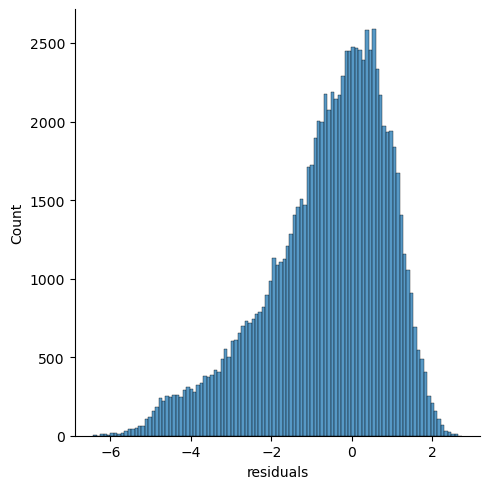

In [25]:
sns.displot(residuals['residuals'])

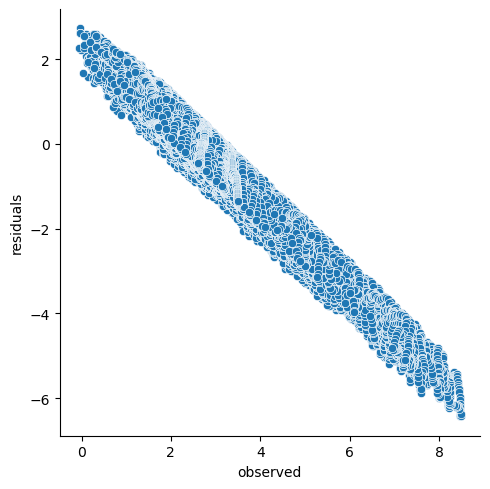

In [26]:
sns.relplot(data=residuals, x='observed', y='residuals')

## Exploratory PCA

In [27]:
def perform_pca(df, n_components=None):
    # Normalize data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)
    
    # Perform PCA
    if n_components is None:
        n_components = min(df.shape[1], df.shape[0])
    pca = PCA(n_components=n_components).set_output(transform='pandas')
    X_pca = pca.fit_transform(data_scaled)
    
    # Gather PCA statistics
    explained_variance_ratio = pca.explained_variance_ratio_
    components = pca.components_
    
    # Create a DataFrame for explained variance ratio
    df_expl_vari_ratio = pd.DataFrame(explained_variance_ratio,
                                      columns=['Explained Variance Ratio'],
                                      index=[f'PC-{i+1}' for i in range(n_components)])
    
    # Create a DataFrame for components
    df_components = pd.DataFrame(components, 
                                 columns=df.columns, 
                                 index=[f'PC-{i+1}' for i in range(n_components)])
    
    # Concatenate DataFrames
    df_pca_stats = pd.concat([df_expl_vari_ratio, df_components], axis=1)
    
    return pca, X_pca, df_pca_stats.T


In [28]:
pca, X_pca, pca_stats = perform_pca(X_train, 4)

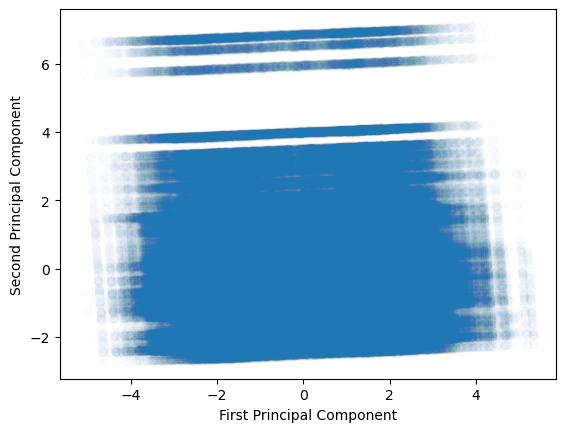

In [29]:
# Visualize the first two principal components
plt.scatter(X_pca['pca0'], X_pca['pca1'], alpha=0.01)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [30]:
pca_stats

,PC-1,PC-2,PC-3,PC-4
Explained Variance Ratio,0.263137,0.217368,0.163704,0.080199
ground_elev,-0.007448,0.156698,0.005473,-0.634866
ini_1_years_water_depth_mean,-0.030535,0.562728,0.005728,0.164950
ini_1_years_water_depth_std,0.006020,-0.171596,-0.006355,0.712949
ini_1_years_water_depth_min,-0.030402,0.568205,0.006641,-0.006952
ini_1_years_water_depth_max,-0.030159,0.550884,0.005237,0.240849
precip_mean,0.003827,-0.004515,0.389745,0.035010
tmean_mean,-0.488405,-0.026907,-0.015437,-0.001840
moisture_mean,0.267662,0.013336,0.306404,0.024439
precip_mean_prev_7d_sum,-0.007288,-0.005940,0.514383,0.014068


In [31]:
pca.components_

array([[-0.00744845, -0.03053477,  0.00602008, -0.03040169, -0.03015905,
         0.00382651, -0.48840473,  0.2676616 , -0.00728837, -0.02891523,
        -0.0366008 , -0.50263358, -0.50414336, -0.4218005 ],
       [ 0.15669753,  0.56272827, -0.17159634,  0.56820452,  0.55088429,
        -0.00451529, -0.02690671,  0.01333629, -0.00594011, -0.00838418,
        -0.00953012, -0.02708487, -0.02681228, -0.02089199],
       [ 0.00547283,  0.00572816, -0.00635484,  0.00664084,  0.00523721,
         0.38974458, -0.01543704,  0.30640441,  0.51438269,  0.53134613,
         0.4465746 ,  0.008827  ,  0.03438655,  0.07870857],
       [-0.63486586,  0.16494964,  0.71294925, -0.00695178,  0.24084852,
         0.03500988, -0.00184032,  0.02443882,  0.01406838, -0.01835698,
        -0.0305112 ,  0.00113815,  0.00344858,  0.00886704]])

## Build pipeline

### Define preprocessing steps

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 435861 entries, 1950-01-02 to 2022-12-31
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ground_elev                   435861 non-null  float64
 1   ini_1_years_water_depth_mean  435861 non-null  float64
 2   ini_1_years_water_depth_std   435861 non-null  float64
 3   ini_1_years_water_depth_min   435861 non-null  float64
 4   ini_1_years_water_depth_max   435861 non-null  float64
 5   precip_mean                   435861 non-null  float64
 6   tmean_mean                    435861 non-null  float64
 7   moisture_mean                 435861 non-null  float64
 8   precip_mean_prev_7d_sum       435861 non-null  float64
 9   precip_mean_prev_30d_sum      435861 non-null  float64
 10  precip_mean_prev_90d_sum      435861 non-null  float64
 11  tmean_mean_prev_7d_mean       435861 non-null  float64
 12  tmean_mean_prev_30d_mean    

In [33]:
# select categorical and numerical column names
#X_cat_columns = X_train.select_dtypes(exclude="number").columns
X_num_columns = X_train.select_dtypes(include="number").columns

# create numerical pipeline
num_pipe = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='mean')), # probably not needed...
           ('num_scaler', MinMaxScaler())
          ])

# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
#categoric_pipe = Pipeline(
#    steps=[('cat_imputer', SimpleImputer(strategy='constant', 
#                                         fill_value='na')), 
#           ('cat_encoder', OneHotEncoder(drop='first', 
#                                         sparse_output=False, 
#                                         handle_unknown='ignore'))
           #('cat_encoder', OrdinalEncoder())
#          ])

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, X_num_columns), 
        #('cat', categoric_pipe, X_cat_columns)
    ],
    #remainder='passthrough'
).set_output(transform='pandas')

In [35]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  MinMaxScaler())]),
                                 Index(['ground_elev', 'ini_1_years_water_depth_mean',
       'ini_1_years_water_depth_std', 'ini_1_years_water_depth_min',
       'ini_1_years_water_depth_max', 'precip_mean', 'tmean_mean',
       'moisture_mean', 'precip_mean_prev_7d_sum', 'precip_mean_prev_30d_sum',
       'precip_mean_prev_90d_sum', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean'],
      dtype='object'))])

### Define regressors to test

In [69]:
regressors = [
    #('DecisionTree', DecisionTreeRegressor()),
    #('SGD', SGDRegressor()),
    #('LinReg', LinearRegression()),
    ('PLS', PLSRegression()),
    #('RandForest', RandomForestRegressor()) # best so far but costly (>10 min)
]

### Create a pipeline for each classifier

In [70]:
pipelines = {}
for name, reg in regressors:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('selector', SelectKBest(score_func=f_regression)),
        #('selector', RFECV(estimator=DecisionTreeRegressor())),
        #('feature_selection', SelectFromModel(DecisionTreeRegressor())),
        ('regressor', reg)
     ]).set_output(transform="pandas")
    pipelines[name] = pipeline


In [71]:
pipelines['PLS']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['ground_elev', 'ini_1_years_water_depth_mean',
       'ini_1_years_water_depth_std', 'ini_1_years_water_depth_min',
       'ini_1_years_water_depth_max', 'precip_mean', 'tmean_mean',
       'moisture_mean', 'precip_mean_prev_7d_sum', 'precip_mean_prev_30d_sum',
       'precip_mean_prev_90d_sum', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean'],
      dtype='object'))])),
                ('regressor', PLSRegression())])

## Inspect models

stats from dummy model: 

MAE 1.180524150300254

RMSE 1.5993132760325228

MAPE 495545893932.64526

R2 -0.3085209566128313

In [72]:
predictions = {}
metrics = {}
residuals = {}

for name in pipelines:
    print(name)
    pipe = pipelines[name]

    #print('FITTING')
    pipe.fit(X_train, y_train)

    #print('PREDICTING')
    y_pred = pipe.predict(X_test)

    # save
    predictions[name] = y_pred
    metrics[name] = calc_metrics(y_test, y_pred)
    residuals[name] = calc_residuals(y_test, y_pred)

PLS
MAE 0.7972072739621795
RMSE 0.9726732881218663
MAPE 0.34302935603819784
R2 0.5646576076159318


In [73]:
#residuals['DecisionTree']

In [74]:
compare_models = pd.DataFrame(metrics)
compare_models

,PLS
MAE,0.797207
MAPE,0.343029
R2,0.564658
RMSE,0.972673


PLS


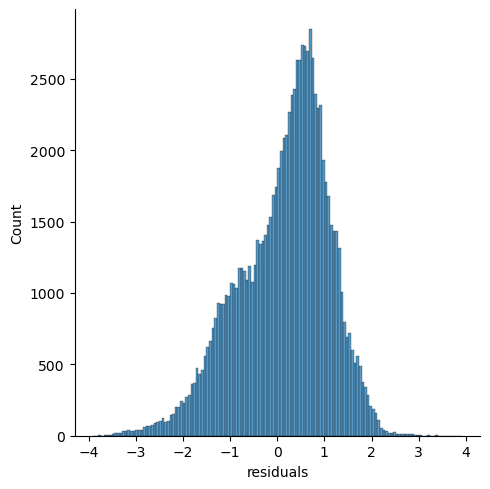

In [75]:
for name in residuals:
    print(name)
    r = residuals[name]
    sns.displot(r['residuals'])

PLS (95847, 3)


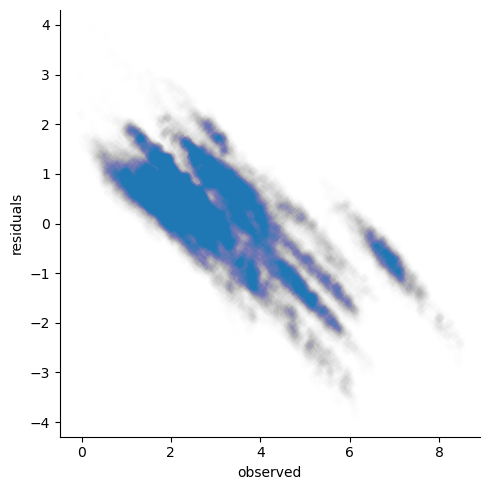

In [76]:
for name in residuals:
    r = residuals[name]
    print(name, r.shape)
    sns.relplot(data=r, x='observed', y='residuals', alpha=0.005)

In [77]:
y_pred = pd.DataFrame(y_pred, columns=['pred_water_depth'])
y_pred.index = info_test.index
#y_pred

In [78]:
test = pd.concat([info_test, X_test, y_test, y_pred],
                 axis='columns')

In [79]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95847 entries, 1950-01-02 to 2022-12-31
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   station_id                    95847 non-null  int64         
 1   date                          95847 non-null  datetime64[ns]
 2   ground_elev                   95847 non-null  float64       
 3   ini_1_years_water_depth_mean  95847 non-null  float64       
 4   ini_1_years_water_depth_std   95847 non-null  float64       
 5   ini_1_years_water_depth_min   95847 non-null  float64       
 6   ini_1_years_water_depth_max   95847 non-null  float64       
 7   precip_mean                   95847 non-null  float64       
 8   tmean_mean                    95847 non-null  float64       
 9   moisture_mean                 95847 non-null  float64       
 10  precip_mean_prev_7d_sum       95847 non-null  float64       
 11  precip_mean

In [80]:
test.describe()

,station_id,date,ground_elev,ini_1_years_water_depth_mean,ini_1_years_water_depth_std,ini_1_years_water_depth_min,ini_1_years_water_depth_max,precip_mean,tmean_mean,moisture_mean,precip_mean_prev_7d_sum,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,water_depth,pred_water_depth
count,95847.000000,95847,95847.000000,95847.000000,95847.000000,95847.000000,95847.000000,95847.000000,95847.000000,95847.000000,95847.000000,95847.000000,95847.000000,95847.000000,95847.000000,95847.000000,95847.000000,95847.000000
mean,13590.716089,1993-11-17 21:09:14.270869248,92.135864,3.083428,0.213884,2.641749,3.425835,1.901244,10.437147,75.597036,13.094916,56.097389,168.256600,10.421076,10.416283,10.403006,3.135673,3.280821
min,12890.000000,1950-01-02 00:00:00,87.440000,0.693962,0.021213,0.040000,0.900000,0.000000,-14.933333,32.250000,0.000000,0.325000,41.440000,-10.571429,-8.513333,-4.064444,-0.060000,1.125660
25%,13023.000000,1977-11-14 00:00:00,89.880000,1.904906,0.124956,1.300000,2.150000,0.000000,4.675000,66.750000,2.975000,33.687500,126.950000,4.755102,4.570833,4.901111,2.030000,2.500922
50%,13514.000000,1996-02-12 00:00:00,91.810000,2.806538,0.165255,2.470000,3.100000,0.116667,10.600000,77.666667,9.525000,51.940000,163.725000,10.410714,10.344762,10.388333,2.870000,3.089421
75%,13748.000000,2012-09-04 12:00:00,94.260000,4.236792,0.265538,3.780000,4.360000,2.080000,16.425000,85.714286,19.225000,73.987500,204.500000,16.425714,16.531333,16.108254,3.920000,3.934740
max,17324.000000,2022-12-31 00:00:00,99.380000,7.138302,0.770682,6.950000,7.490000,51.200000,30.000000,99.500000,90.025000,210.500000,384.700000,28.671429,24.437778,22.301852,8.490000,6.629104
std,647.988568,NaN,2.771124,1.551366,0.150687,1.632308,1.588879,3.865328,7.466317,12.606224,12.890167,30.365434,55.310109,7.094289,6.684492,5.997168,1.474191,1.047823


In [81]:
test.head()

,station_id,date,ground_elev,ini_1_years_water_depth_mean,ini_1_years_water_depth_std,ini_1_years_water_depth_min,ini_1_years_water_depth_max,precip_mean,tmean_mean,moisture_mean,precip_mean_prev_7d_sum,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,water_depth,pred_water_depth
date,,,,,,,,,,,,,,,,,,
1950-01-02,14082,1950-01-02,92.37,3.496226,0.137746,3.29,3.80,7.3250,0.2000,79.857143,7.5250,57.825,144.8500,2.825000,4.0775,6.524861,3.97,3.696769
1950-01-02,12942,1950-01-02,90.90,1.996667,0.176909,1.75,2.21,7.3250,0.2000,79.857143,7.5250,57.825,144.8500,2.825000,4.0775,6.524861,2.19,2.641985
1950-01-02,12900,1950-01-02,87.81,0.766792,0.039651,0.54,0.90,7.3250,0.2000,79.857143,7.5250,57.825,144.8500,2.825000,4.0775,6.524861,1.31,1.722027
1950-01-09,14082,1950-01-09,92.37,3.496226,0.137746,3.29,3.80,0.0125,0.8375,90.714286,8.1375,46.750,146.4625,3.633929,3.3100,5.763333,3.98,3.696490
1950-01-09,12942,1950-01-09,90.90,1.996667,0.176909,1.75,2.21,0.0125,0.8375,90.714286,8.1375,46.750,146.4625,3.633929,3.3100,5.763333,2.19,2.641707


In [82]:
test.station_id.unique()

array([14082, 12942, 12900, 13141, 13023, 12907, 12944, 13735, 13487,
       13485, 13627, 13584, 13727, 13776, 13803, 13757, 13761, 13751,
       13748, 13795, 13766, 13769, 13508, 12890, 12898, 15892, 12927,
       13704, 13597, 13568, 13439, 13823, 13514, 13626, 13500, 13502,
       13696, 13045, 13470, 15154, 17324, 15714])

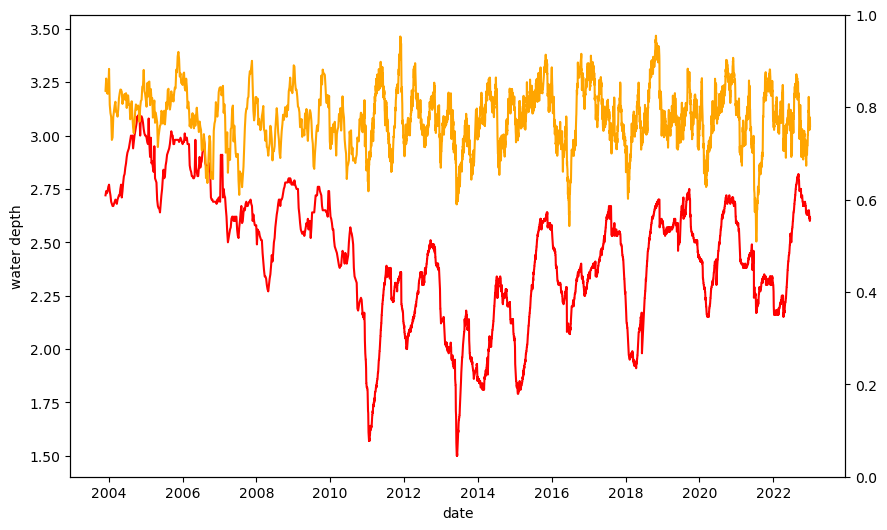

In [83]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

data = test.loc[test.station_id == 15154]

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='r',
             data=data,
             ax=ax)

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="pred_water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='orange',
             data=data,
             ax=ax)

# Create a secondary y-axis
ax2 = ax.twinx()

# Plot the second DataFrame on the secondary y-axis
#sns.lineplot(x="date", y="tmean_mean_prev_7d_mean", 
#             data=data,#['1983-01':'1985-01'], # filter dates here
#             ax=ax2, 
#             color='b'
#            )

# Optionally, set labels for the y-axes
ax.set_ylabel('water depth')
#ax2.set_ylabel('Y2 Label')

# Set the x-axis limits
#start_date = pd.to_datetime('1970-01-01')
#end_date = pd.to_datetime('1985-01-10')
#plt.xlim(start_date, end_date)

# Show the plot
plt.show()